In [34]:
import pandas as pd
import numpy as np
import plotly
from plotly import graph_objs as go

In [33]:
import plotly.io as pio
pio.templates.default = "presentation"

## The Data

Vacasa would like to add a section to their abandoned cart email which displays 3 similar units to the unit the customer abandoned in their cart. **The objective is to create a programmatic solution to determining 3 similar units for the abandoned cart email, with the ultimate goal of maximizing conversion/revenue from the email.** There are 4 datasets provided, they are described below.

- “official_reservations” is a record of all reservations for Vacasa units made from both
vacasa.com and our channel partners like AirBnB. What you are getting is a subset of
our full table.
- “Units” contains descriptive fields about our units. You are seeing a subset of all of our
units that excludes lat and lng for privacy reasons.
- “Segment page views” contains a list of all page views of unit pages on the website (these
are when a user clicks through to an individual unit). The key here is an anonymous id,
which is an id assigned to a particular browser that visits our web page. Theoretically,
whenever that same browser comes back, it should be assigned the same anonymous
id through browser cookies.
- “segment_reservations” contains a list of the browser sessions that ended in a
reservation. It is joinable to the unit pages viewed table on the anonymous id and
joinable to the official reservations table on the reservation id. You are seeing a masked
subset of our full dataset.

## Exploratory Analysis

### *official_reservations* Dataset

In [23]:
official_reservations = pd.read_csv('data/official_reservations.csv')
official_reservations.head()

,cancelled,unitid,creationdate,firstnight,lastnight,reservation_source_id
0,0,4703,2018-01-01 08:42:41,2018-02-08 00:00:00,2018-02-11 00:00:00,8
1,1,9980,2018-01-01 19:08:32,2018-04-07 00:00:00,2018-04-13 00:00:00,1
2,0,10938,2018-01-02 01:14:25,2018-01-09 00:00:00,2018-01-10 00:00:00,8
3,0,6057,2018-01-02 10:26:26,2018-07-23 00:00:00,2018-07-25 00:00:00,12
4,1,13154,2018-01-02 09:51:18,2018-01-12 00:00:00,2018-01-14 00:00:00,1


In [59]:
official_reservations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92317 entries, 0 to 92316
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   cancelled              92317 non-null  int64 
 1   unitid                 92317 non-null  int64 
 2   creationdate           92317 non-null  object
 3   firstnight             92317 non-null  object
 4   lastnight              92317 non-null  object
 5   reservation_source_id  92317 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 4.2+ MB


There are 6 feature columns in this dataset with no missing values. 

In [61]:
official_reservations.cancelled.value_counts()

0    67923
1    24394
Name: cancelled, dtype: int64

The *cancelled* feature is likely 0 if the reservation was cancelled before the reservation date or 1 if not.

The *unitid* corresponds to the unique key of each unit and can be joined with the *unitid* in the *units* table.

In [26]:
print(f'First reservation date: {official_reservations.creationdate.min()}')

First reservation date: 2018-01-01 00:12:25


In [27]:
print(f'Last reservation date: {official_reservations.creationdate.max()}')

Last reservation date: 2018-12-31 23:58:41


The *official_reservations* dataset includes reservations made in the year 2018. We can assume that the other 3 datasets correspond to the data that existed that year as well, as it's very possible that the data for each unit on the vacasa website has changed since 2018. 

In [54]:
official_reservations.reservation_source_id.nunique()

28

*reservation_source_id* is likely the unique identifier for vacasa or other channel partners through which the reservation was made. There are 28 unique *reservation_source_id*s.

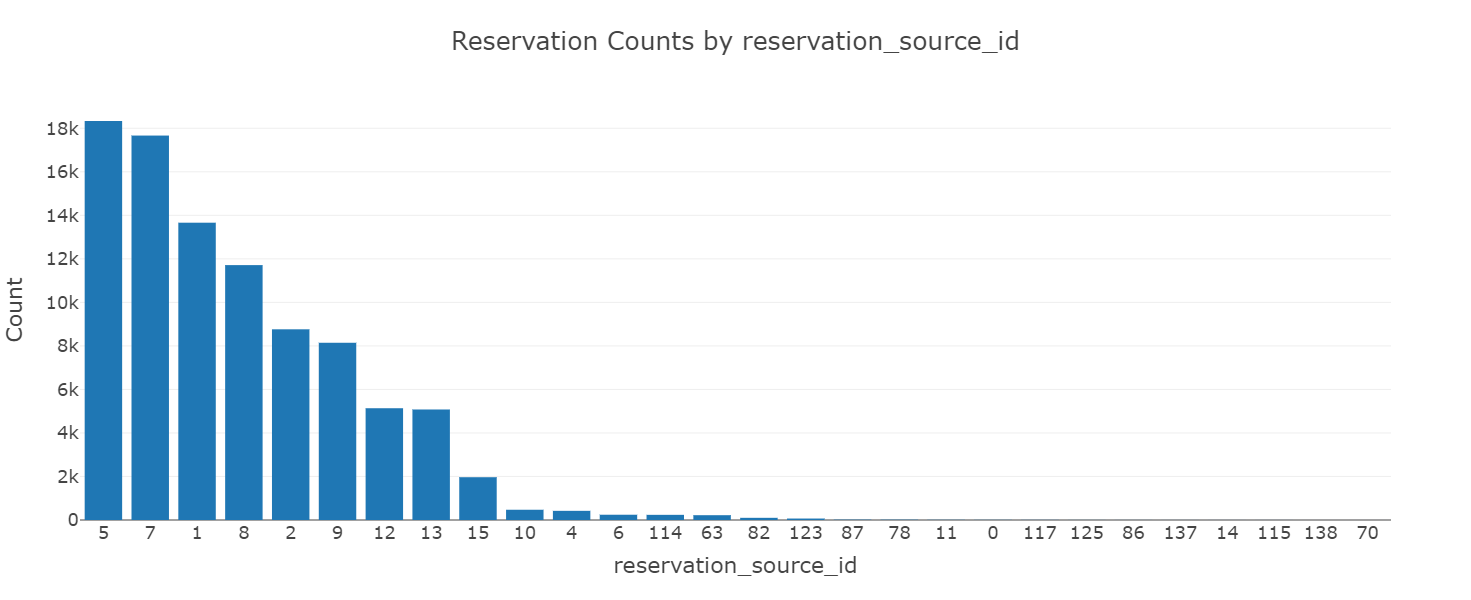

In [52]:
source_id_counts = official_reservations.reservation_source_id.value_counts()
fig = go.Figure(go.Bar(x=source_id_counts.index, y=source_id_counts))
fig.update_layout(title='Reservation Counts by reservation_source_id',
                  yaxis={'title':'Count'},
                  xaxis={'title':'reservation_source_id', 'type':'category'},
                  width=1200,
                  height=600)

fig.show()

Above is a pareto of the number of reservations made for each *reservation_source_id* in 2018.  Indeed, the top 6 sources make up 85% of all reservations in the dataset.

### *Units* Dataset

In [6]:
units = pd.read_csv('data/units.csv')

# set unitid as the index
units.set_index('unitid', inplace=True)
units.head()

,cityid,avgbaserate,dogs,maxoccupancyadults,fullbaths,terminated,bedrooms,beachaccess,hottub
unitid,,,,,,,,,
251,41,0,NaN,NaN,2,1,4.0,Drive 5 miles south on 89 to Tahoe City. Afte...,-1.0
536,44,0,NaN,0.0,2,1,5.0,Walk down Ellis to the Lake.,-1.0
876,84,0,NaN,NaN,3,1,4.0,0,1.0
1332,130,0,1.0,NaN,4,1,4.0,NaN,1.0
1374,43,0,NaN,NaN,2,1,3.0,NaN,NaN


In [7]:
units.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2181 entries, 251 to 25557
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cityid              2181 non-null   int64  
 1   avgbaserate         2181 non-null   int64  
 2   dogs                548 non-null    float64
 3   maxoccupancyadults  412 non-null    float64
 4   fullbaths           2181 non-null   int64  
 5   terminated          2181 non-null   int64  
 6   bedrooms            2176 non-null   float64
 7   beachaccess         465 non-null    object 
 8   hottub              2120 non-null   float64
dtypes: float64(4), int64(4), object(1)
memory usage: 170.4+ KB


The *Units* dataset contains 9 feature columns (above). There are a total of 2,181 individual units. Only 4 of the 9 features contain no null values. Since no information about the features is provided, we will make some assumptions about how the data is collected and how the values should be interpreted. I'll do this as I explore the dataset. I did discover that I can look up the actual listings on the vacasa website using the *unitid*, however many of the units no longer exist on the website. I'll be using ones that do as an example for interpreting the features.

The first unit I'm going to be exploring the data features with is unit 24292. The unit data is shown below, along with the vacasa listing URL and a couple of screenshots of the unit listing.

In [71]:
units.loc[24292]

cityid                545
avgbaserate             0
dogs                  NaN
maxoccupancyadults    0.0
fullbaths               2
terminated              0
bedrooms              2.0
beachaccess           NaN
hottub                1.0
Name: 24292, dtype: object

https://www.vacasa.com/unit/24292

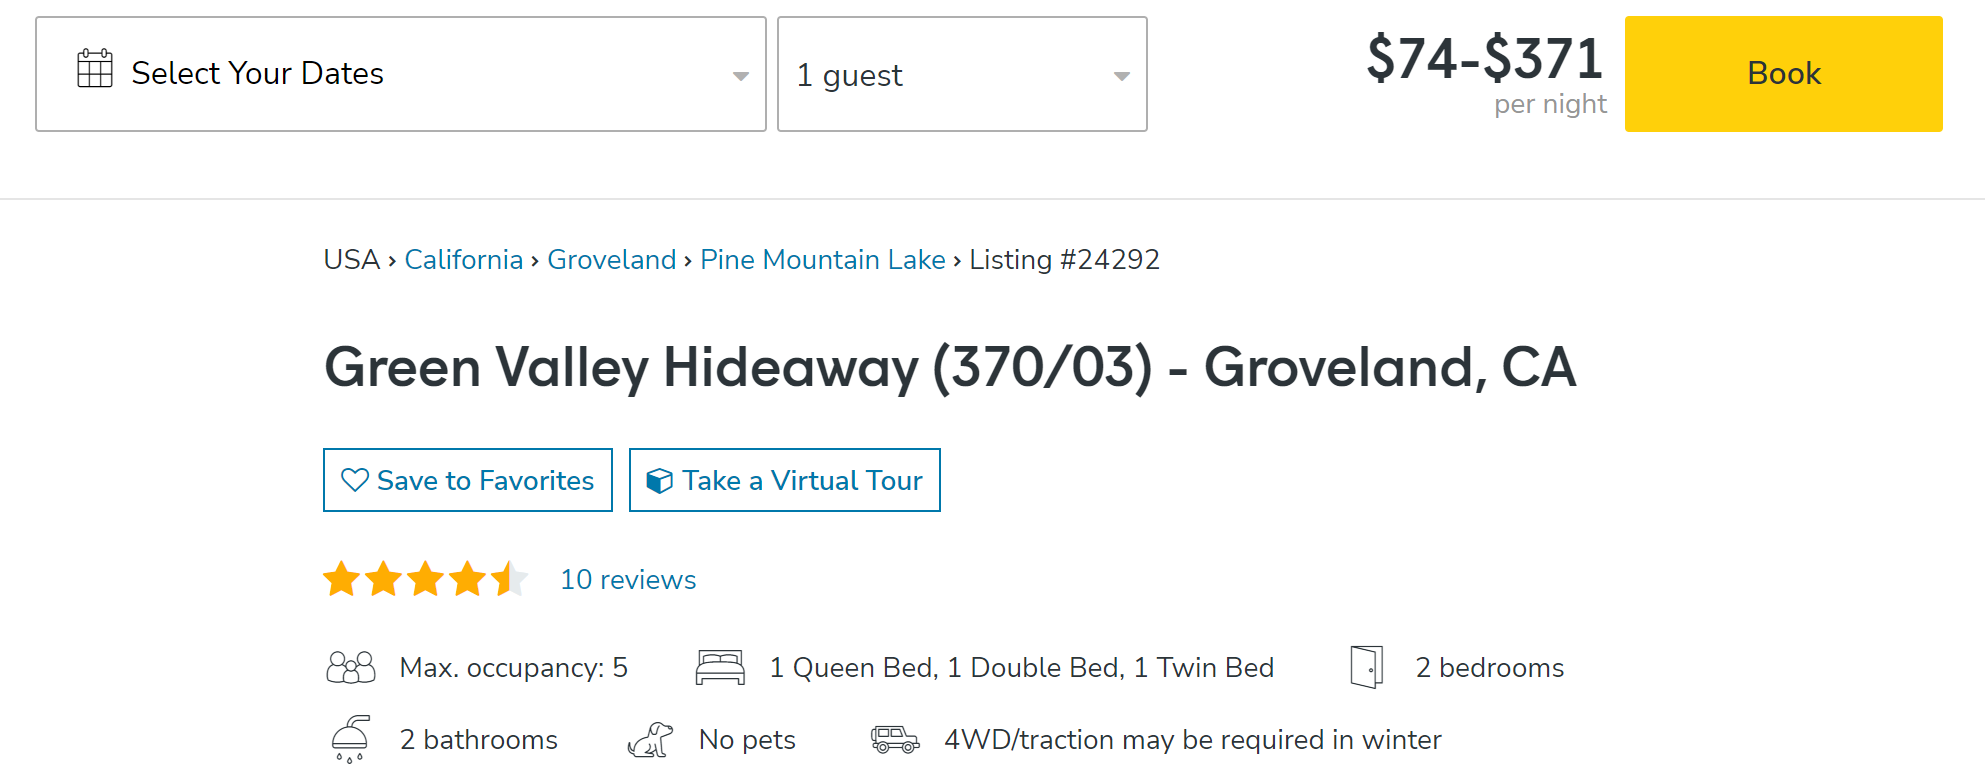

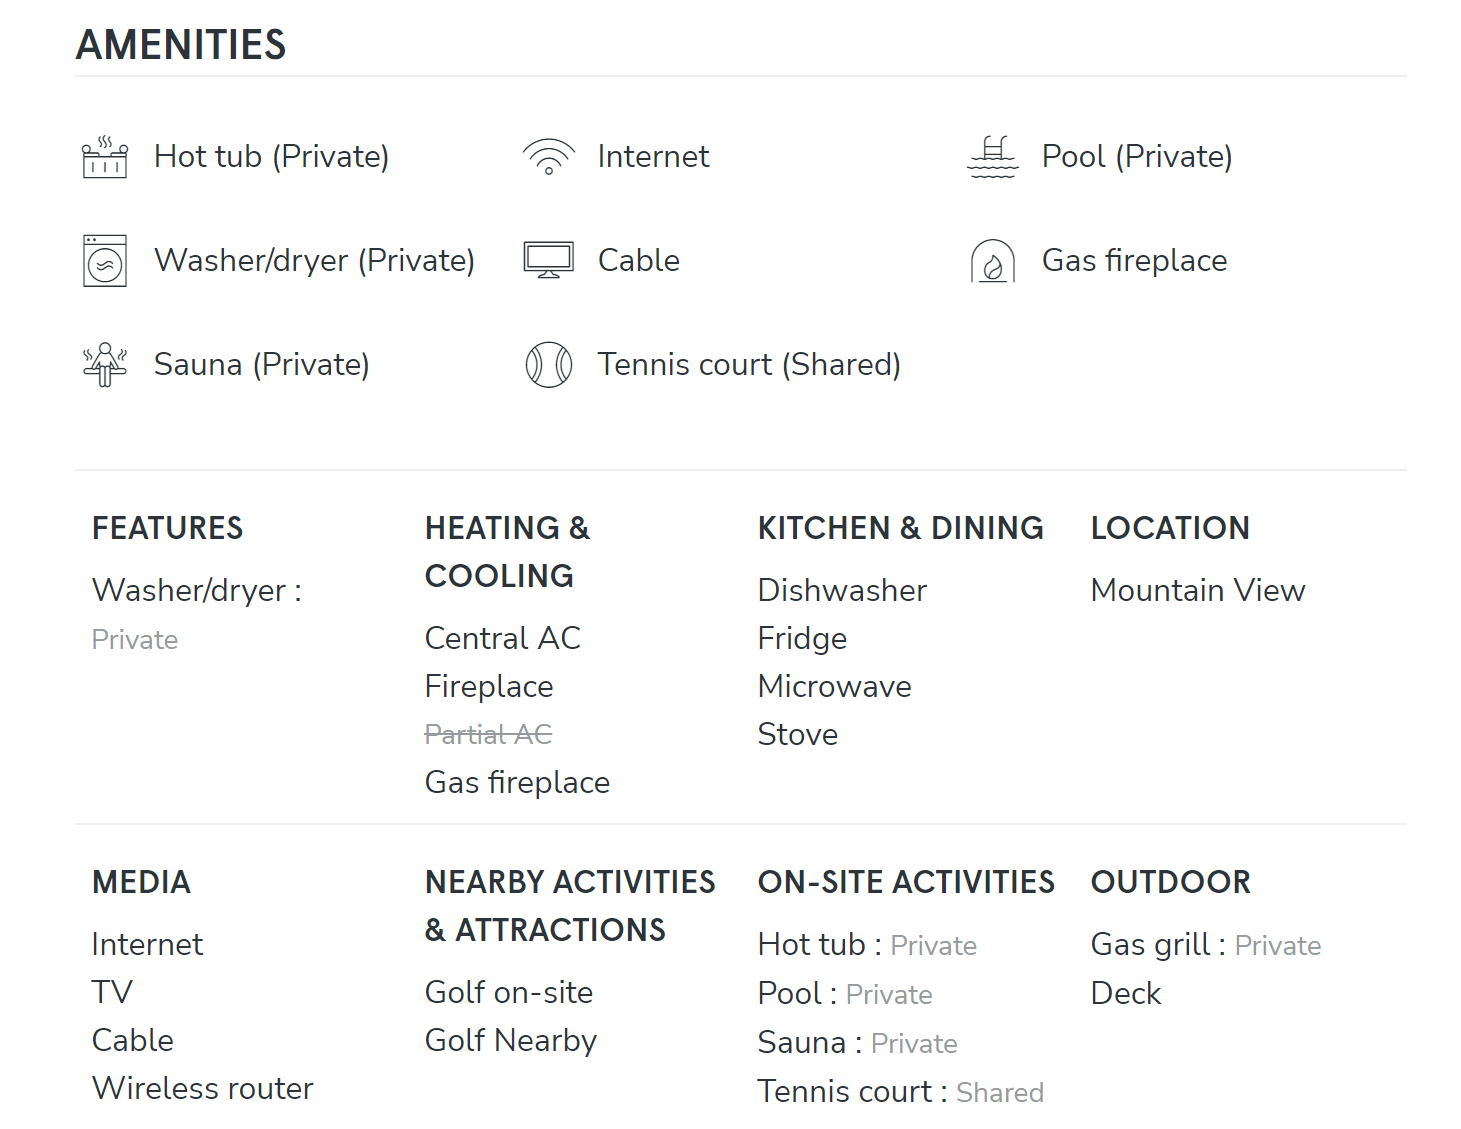

We do have to be careful in this comparison since the vacasa listing is current while the data we are exploring is a snapshot from 2018. As mentioned before, the data for each unit now may look very different. Let's explore each feature in the units table while using this specific listing for reference.

In [9]:
units.cityid.nunique()

119

*cityid* seems pretty straightforward and is likely a unique identifier for the city that the unit is in. There are 119 unique cities with no missing values.

In [72]:
units.avgbaserate.value_counts()

0       185
189      20
158      19
152      19
190      18
       ... 
644       1
680       1
712       1
724       1
1097      1
Name: avgbaserate, Length: 415, dtype: int64

Since the nightly price of a rental can vary with the time of year, *avgbaserate* is likely the yearly average of the nightly rate of the rental. It's unclear why a unit would have a value of 0 for this feature. The unit 24292 for example has an *avgbaserate* value of 0, while on the actual listing the rate varies between 74 - 371 per night.

In [12]:
units.dogs.value_counts(dropna=False)

NaN    1633
1.0     529
0.0      19
Name: dogs, dtype: int64

The *dogs* feature is a binary feature taking on a value of 1 if pets are allowed, otherise 0 if not. The majority (1633) of units are missing data for this feature. 

In [14]:
units.maxoccupancyadults.value_counts(dropna=False)

NaN     1769
0.0      176
8.0       71
6.0       67
4.0       49
2.0       11
10.0      11
5.0       10
12.0       5
9.0        4
7.0        4
3.0        3
14.0       1
Name: maxoccupancyadults, dtype: int64

*maxoccupancyadults* also has mostly missing values (1769 out of 2181). Besides missing values, the majority of the data has a value of 0. A value of 0 may correspond to 'no limit' in occupancy. Browsing through dozens of units in different cities on the actual Vacasa website, I was never able to find a unit that didn't have a max occupancy. Our sample 24292 for example also has a value of 0 but on the actual listing it has a max occupancy of 5. Of course, this feature may have been changed since this data was initially collected. For now, we'll assume the value 0 corresponds to 'no limit'.

In [16]:
units.fullbaths.value_counts()

2     1167
1      497
3      381
4       82
0       21
5       20
6        7
7        3
10       2
11       1
Name: fullbaths, dtype: int64

*fullbaths* has no missing values and is the number of full baths.

In [17]:
units.terminated.value_counts()

0    1664
1     517
Name: terminated, dtype: int64

*terminated* also has no missing values and is likely a 0 if the reservation was not cancelled and a 1 

In [70]:
units[(units.terminated==0) & (units.maxoccupancyadults==0)]

,cityid,avgbaserate,dogs,maxoccupancyadults,fullbaths,terminated,bedrooms,beachaccess,hottub
unitid,,,,,,,,,
5659,41,0,1.0,0.0,3,0,4.0,NaN,-1.0
24292,545,0,NaN,0.0,2,0,2.0,NaN,1.0
4281,464,128,NaN,0.0,1,0,2.0,NaN,-1.0
524,43,158,NaN,0.0,2,0,3.0,1,2.0
6257,204,230,1.0,0.0,2,0,4.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...
11820,32,448,NaN,0.0,5,0,6.0,NaN,1.0
12601,84,201,1.0,0.0,2,0,2.0,NaN,1.0
13846,32,199,NaN,0.0,1,0,1.0,NaN,-1.0


In [64]:
units[units.terminated==1]

,cityid,avgbaserate,dogs,maxoccupancyadults,fullbaths,terminated,bedrooms,beachaccess,hottub
unitid,,,,,,,,,
251,41,0,NaN,NaN,2,1,4.0,Drive 5 miles south on 89 to Tahoe City. Afte...,-1.0
536,44,0,NaN,0.0,2,1,5.0,Walk down Ellis to the Lake.,-1.0
876,84,0,NaN,NaN,3,1,4.0,0,1.0
1332,130,0,1.0,NaN,4,1,4.0,NaN,1.0
1374,43,0,NaN,NaN,2,1,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
20396,1338,822,NaN,NaN,4,1,5.0,NaN,-1.0
20414,3272,307,NaN,NaN,2,1,3.0,NaN,-1.0
20759,566,278,NaN,NaN,2,1,3.0,NaN,-1.0



- *cityid* is a unique identifier for the city that the unit is in.
- Since the nightly price of a rental can vary with the time of year, *avgbaserate* is likely the yearly average of the nightly rate of the rental.
- *dogs* 